In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt
from itertools import *
from pylab import *
import time
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay, ConvexHull
from collections import defaultdict, Counter
import itertools
from itertools import combinations
from shapely.geometry import LineString, MultiPolygon, MultiPoint, Point
import collections
from matplotlib.collections import LineCollection
from collections import OrderedDict
from scipy.ndimage import label
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import networkx as nwx
import math
import random
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
import scipy.stats as stats 

matplotlib.rcParams.update({'font.size': 9})
matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'

nx = 25; ny = 20;

a,b = np.array([1,0]), np.array([-1/2, 0.5*np.sqrt(3)])
var_position = 0.25;

points = [ i*a + j*b + 0.25*a*(2*j + 1 + (-1)**(j+1)) + np.random.uniform(low=-var_position, high=var_position, size=[2])  
              for i in range(0, nx)
              for j in range(0, ny)]

ex = int(0.5*((-1)**ny - 1))
ex2 = int(0.5*((-1)**(ny) + 1))

points_border_top = [ i*a + j*b + 0.25*a*(2*j + 1 + (-1)**(j+1)) + np.random.uniform(low=-var_position, high=var_position, size=[2])  
              for i in range(int(ex), nx + ex2)
              for j in [ny]]

points_border_bottom = [ i*a + j*b + 0.25*a*(2*j + 1 + (-1)**(j+1)) + np.random.uniform(low=-var_position, high=var_position, size=[2])  
              for i in range(int(ex), nx )
              for j in [-1]]

points_border_left = [ (i-0.5)*a + j*b + 0.25*a*(2*j + 1 + (-1)**(j+1)) + np.random.uniform(low=-var_position, high=var_position, size=[2])  
              for i in [-0.5]
              for j in range(-1, ny,1)]

points_border_right = [ (i-0.5)*a + (j)*b + 0.25*a*(2*(j) + 1 + (-1)**((j)+1)) + np.random.uniform(low=-var_position, high=var_position, size=[2])  
              for i in [nx+0.5]
              for j in range(0, ny,1)]


points.extend(points_border_top)
points.extend(points_border_bottom)
points.extend(points_border_left)
points.extend(points_border_right)

#plt.figure(3)
#plt.scatter(*zip(*points))

#plt.scatter(*zip(*points_border_top))
#plt.scatter(*zip(*points_border_bottom))
#plt.scatter(*zip(*points_border_left))
#plt.scatter(*zip(*points_border_right))


extra_points = 2000;
points = np.array(points)


tri = Delaunay(points)
vor = Voronoi(points)
neiList=defaultdict(set)

new_len = nx*ny

for Q in tri.simplices:
    for i,j in itertools.combinations(Q,2):
        if (i < nx*ny) & (j < nx*ny):
            neiList[i].add(j)
            neiList[j].add(i)

dist_centroids = {}
for k in range(0, new_len):
    for j in neiList[k]:
        dist_centroids[k, j] = np.linalg.norm(points[k] - points[j])
        
def index_vertices(a1,a2): ##this computes the corresponding index for vertices between cells (a1,a2)
    ss = -1; BB = [];     
    for Q in tri.simplices:
        ss = ss + 1
        for i,j in itertools.combinations(Q,2):
            if ([i,j] == [a1,a2]) or ([i,j] == [a2,a1]):
                BB.append(ss)
    return np.array(BB)

length = {}  ###lenght of shared sides between cells k and j
sum_len_neig = {} ###sum of these lengths shared between neighbours
for k in range(0,new_len):
    sl = 0;
    for j in neiList[k]:
        LL = vor.vertices[index_vertices(k,j)]
        length[k,j] = np.sqrt((LL[0] - LL[1])[0]**2 + (LL[0] - LL[1])[1]**2)
        sl = sl + length[k,j]
    sum_len_neig[k] = sl

#print( list(set(length)))
#for i in range(nx*ny, len(points) ):  #pq he de fer això? pq es creen nouse elements a neiList??? vale, ja està aclarit!
#    neiList.pop(i)

perimeter = np.zeros(vor.npoints)  
area = np.zeros(vor.npoints)

for i, reg_num in enumerate(vor.point_region):
    indices = vor.regions[reg_num]
    if -1 in indices: # some regions can be opened
        perimeter[i] = perimeter[i]  ## = np.infnp.inf
        area[i] = area[i] ## = np.inf
    else:
        perimeter[i] = ConvexHull(vor.vertices[indices]).area ##in 2D this is the perimeter
        area[i] = ConvexHull(vor.vertices[indices]).volume ##in 2D this is the area
        #hull = ConvexHull(vor.vertices[indices])
        
p = tri.points[tri.simplices]

#triangle vertices
A = p[:,0,:].T
B = p[:,1,:].T
C = p[:,2,:].T

#see http://en.wikipedia.org/wiki/Circumscribed_circle#Circumscribed_circles_of_triangles
#the following is just a direct transcription of the formula there
a1 = A - C
b1 = B - C

def dot2(u, v):
    return u[0]*v[0] + u[1]*v[1]

def cross2(u, v, w):
    """u x (v x w)"""
    return dot2(u, w)*v - dot2(u, v)*w

def ncross2(u, v):
    """|| u x v ||^2"""
    return sq2(u)*sq2(v) - dot2(u, v)**2

def sq2(u):
    return dot2(u, u)

cc = cross2(sq2(a1)*b1 - sq2(b1)*a1, a1, b1) / (2*ncross2(a1, b1)) + C

#Voronoi edges
vc = cc[:,tri.neighbors]
vc[:,tri.neighbors == -1] = np.nan # edges at infinity, plotting those would need more work...


#Gabriel graph
def compute_gabriel_graph(points):
    #Delaunay triangulation
    delaunay = Delaunay(points)
    edges = []

    for simplex in delaunay.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                p1, p2 = points[simplex[i]], points[simplex[j]]
                mid_point = (p1 + p2)/2
                radius = np.linalg.norm(p1 - p2)/2 

                is_gabriel = True

                #check if any other point lies within the circle
                for k in range(len(points)):
                    if k != simplex[i] and k != simplex[j]:  # Exclude points on the current edge
                        if np.linalg.norm(points[k] - mid_point) < radius:
                            is_gabriel = False
                            break

                if is_gabriel:
                    edges.append((simplex[i], simplex[j]))

    return edges

###Moran's I
def compute_morans_I(neighbor_dict, dark_cells):

    all_cells = set(neighbor_dict.keys()) | {n for neighbors in neighbor_dict.values() for n in neighbors}

    #dark cells = 1, light cells = 0
    cell_values = {cell: 1 if cell in dark_cells else 0 for cell in all_cells}

    x_values = np.array([cell_values[cell] for cell in all_cells])
    x_mean = np.mean(x_values)

    denominator = sum((x_values - x_mean)**2)
    if denominator == 0:
        return np.nan

    numerator = 0
    W = sum(len(neighbors) for neighbors in neighbor_dict.values())

    for i in all_cells:
        neighbors = neighbor_dict.get(i, set())
        for j in neighbors:
            if j in all_cells:
                wij = 1
                numerator += wij * (cell_values[i] - x_mean) * (cell_values[j] - x_mean)

    moran_I = (len(all_cells) / W) * (numerator / denominator) if W > 0 else np.nan
    return moran_I


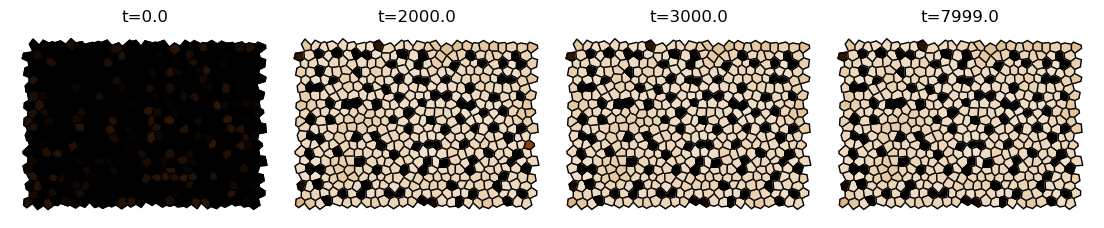

Simulation 0
Proportion of dark cells: 0.198


/var/folders/_r/xkdhrm6554zgpd1gd9935s3m0000gq/T/ipykernel_36878/3928830562.py:264: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  dark_neighbors = sum(1 for nei in neiList[cell] if dark_cells[nei])
/var/folders/_r/xkdhrm6554zgpd1gd9935s3m0000gq/T/ipykernel_36878/3928830562.py:309: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  avg_diff = sum(abs(cell_values[cell] - cell_values[n]) for n in nn)/len(nn)
/var/folders/_r/xkdhrm6554zgpd1gd9935s3m0000gq/T/ipykernel_36878/2165016072.py:208: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  W = sum(len(neighbors) for neighbors in neighbor_dict.values(

KeyboardInterrupt: 

In [6]:
start = time.time()

def diff(x,k):
    K = 0;
    for i in neiList[k]:
        K = K + (x[i] - x[k])*length[k,i]/(dist_centroids[k,i])
    return K/area[k]

a0 = 0.75; alpha = 2; b0 = 0.1; beta = 7.; ku = 1.2; kv = 2;
kc = 1;  nu = 4; nv = 4; du = 1; dv = 1;
Du = 0.; Dv = 4.;

# dt = 0.02; total_time = 1000; #for the statistics, just to be sure we are in the stationary state

dt = 0.05; total_time = 400; #for trying things

U0 = 1.35; V0 = 0.4;
noise = 0.1;

Nsim = 10;

p = 0.15

DENSITY_DARK = {}
LSP = {} #dictionary for the length of the shortest path between pairs of dark cells
CSD = {} #dictionary for the cluster size distribution
CS = {} #dictionary for the cluster sizes
ND = {} #dictionary for the neighbour density
ANGLES = {} #dictionary for the neighbour density
ORDER = {}
MORAN = {}

for kk in range(0,Nsim):

    U = U0*(1 + noise*(np.random.uniform(low = -1,high = 1,size = nx*ny + extra_points)))
    V = V0*(1 + noise*(np.random.uniform(low = -1,high = 1,size = nx*ny + extra_points)))

    #U = np.random.normal(p, 2, size = nx*ny + extra_points)
    #V = np.random.normal(p, 2, size = nx*ny + extra_points)

    T = np.zeros(int(total_time/dt)+1)
    UU = np.zeros((nx*ny + extra_points,int(total_time/dt)+1))
    
    t = 0; s = -1;
    
    U = U[0:new_len]
    UU = UU[0:new_len,:]
    
    bb = beta
    #bb = beta*(1 + 0.4*(np.random.random() - 0.6))
    #Dv = 4*(1 + 0.4*(np.random.random() - 0.5))
    

    #a0 = 0.92*(1 + 0.02*(np.random.random() - 0.5)) ###and beta = 8, lateral inhibition short range
    #a0 = 0.76*(1 + 0.11*(np.random.random() - 0.6))  ###and beta = 8, lateral inhibition long range
    #a0 = 0.67*(1 + 0.08*(np.random.random() - 0.6))  ###and beta = 4.5, lateral inhibition mixed

    while t <= total_time:
        t = t + dt
        T[s] = t
        s = s + 1

        UU[:,s] = U[:]
    
        U_new = U.copy()
        V_new = V.copy()
    
        for j in range(new_len):
            # Compute k1
            k1_U = dt * (a0 + alpha*(U[j]**nu)/(ku**nu + U[j]**nu) - kc*U[j]*V[j] - du*U[j])
            k1_V = dt * (b0 + bb*(U[j]**nv)/(kv**nv + U[j]**nv) + Dv*diff(V, j) - dv*V[j])
            
            # Compute k2
            U_temp = U[j] + k1_U/2
            V_temp = V[j] + k1_V/2
            k2_U = dt * (a0 + alpha*(U_temp**nu)/(ku**nu + U_temp**nu) - kc*U_temp*V_temp - du*U_temp)
            k2_V = dt * (b0 + bb*(U_temp**nv)/(kv**nv + U_temp**nv) + Dv*diff(V, j) - dv*V_temp)
    
            # Compute k3
            U_temp = U[j] + k2_U/2
            V_temp = V[j] + k2_V/2
            k3_U = dt * (a0 + alpha*(U_temp**nu)/(ku**nu + U_temp**nu) - kc*U_temp*V_temp - du*U_temp)
            k3_V = dt * (b0 + bb*(U_temp**nv)/(kv**nv + U_temp**nv) + Dv*diff(V, j) - dv*V_temp)
    
            # Compute k4
            U_temp = U[j] + k3_U
            V_temp = V[j] + k3_V
            k4_U = dt * (a0 + alpha*(U_temp**nu)/(ku**nu + U_temp**nu) - kc*U_temp*V_temp - du*U_temp)
            k4_V = dt * (b0 + bb*(U_temp**nv)/(kv**nv + U_temp**nv) + Dv*diff(V, j) - dv*V_temp)
    
            # Update using weighted sum
            U_new[j] = U[j] + (1/6)*(k1_U + 2*k2_U + 2*k3_U + k4_U)
            V_new[j] = V[j] + (1/6)*(k1_V + 2*k2_V + 2*k3_V + k4_V)
    
            #to check if the neighbours work
            #U[3] = 2
            #U[list(neiList[3])] = 0
    
        U = U_new
        V = V_new
                
    fig1, axs = plt.subplots(1,4,figsize = (14,8))
    fig1.subplots_adjust(wspace = 0.01)
    
    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["w","burlywood","saddlebrown","black"])
    #cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","saddlebrown","burlywood","linen"])
    
    norm1 = mpl.colors.Normalize(vmin=0.5, vmax = 1.3, clip=True)
    sm1 = cm.ScalarMappable(norm=norm1, cmap=cmap1)
    sm1.set_array([]);
    #cbar1 = plt.colorbar(sm1, ax = axs[-1], shrink = 0.6)
    #cbar1.ax.set_ylabel('$U$', fontsize = 20)
    
    s = -1;
    for t in [0,int(total_time/(4*dt)),int(3*total_time/(8*dt)),int(total_time/dt)-1]:
        s = s + 1
        for k in range(new_len):
            region = vor.regions[vor.point_region[k]]
            if not -1 in region:
                polygon = [vor.vertices[i] for i in region]
                axs[s].fill(*zip(*polygon), color=sm1.to_rgba(UU[k,int(t)]))
                poly = patches.Polygon(polygon, edgecolor='black', fill=None, lw=1)
                axs[s].add_patch(poly)
                axs[s].set_aspect('equal', adjustable='box')
                axs[s].axis('off')
                axs[s].set_title(r't=%.1f'%t, fontsize = 12)
                plt.xticks([])
                plt.yticks([])
                #axs[s].scatter(*zip(*points))
                #axs[s].plot(points[0:new_len,0], points[0:new_len,1], '.')
    plt.show()

    threshold = 1.
    dark_cells = U > threshold
    
    all_cells_dict = {index: value for index, value in enumerate(U)}
    dark_dict = {index: value for index, value in enumerate(U) if value >= threshold}
    light_dict = {index: value for index, value in enumerate(U) if value < threshold}
    
    all_indices = list(all_cells_dict.keys())
    dark_indices = list(dark_dict.keys())
    light_indices = list(light_dict.keys())
    
    density_dark_cells = len(dark_dict)/len(U)
    
    print('Simulation', kk)
    print('Proportion of dark cells:', density_dark_cells)
    
    dark_points = points[dark_indices]

    DENSITY_DARK[kk] = density_dark_cells
    
    gabriel_dark = compute_gabriel_graph(dark_points)
    
    G_dark = nwx.Graph()
    for point in dark_points:
        G_dark.add_node(tuple(point))
    G_dark.add_edges_from(gabriel_dark)
    
    G = nwx.Graph()
    
    for simplex in tri.simplices:
        for i in range(len(simplex)):
            for j in range(i + 1, len(simplex)):
                p1 = tuple(points[simplex[i]])
                p2 = tuple(points[simplex[j]])
                distance = np.linalg.norm(points[simplex[i]] - points[simplex[j]])
                G.add_edge(p1, p2, weight=distance)
    
    def find_simplices_from_gabriel_graph(G):
        cliques = list(nwx.find_cliques(G))
        simplices = [clique for clique in cliques if len(clique) >= 3]
        return simplices

    def find_all_cliques(G):
        cliques = list(nwx.find_cliques(G))
        return cliques

    neighbors = {label: [] for label in dark_indices}
    
    #gabriel_dark_simplices = np.array(find_simplices_from_gabriel_graph(G_dark))
    ###making np.array sometimes gives errors because it finds simplices of 4 elements instead of 3, and cannot convert to array
    gabriel_dark_cliques = find_all_cliques(G_dark)

    # Find neighbors from the Gabriel graph
    angles = []
    for clique in gabriel_dark_cliques:
        for i in range(len(clique)):
            for j in range(len(clique)):
                if i != j:
                    p1 = dark_indices[clique[i]]
                    p2 = dark_indices[clique[j]]
                    neighbors[p1].append(p2)

        if len(clique) == 3:
            ppp = [points[dark_indices[point]] for point in clique]    

            distances = squareform(pdist(ppp))
            
            a, b, c = distances[0, 1], distances[1, 2], distances[0, 2]
            
            angle_A = np.arccos((b**2 + c**2 - a**2)/(2*b*c))
            angle_B = np.arccos((a**2 + c**2 - b**2)/(2*a*c))
            angle_C = np.arccos((a**2 + b**2 - c**2)/(2*a*b))
            
            angles.extend([angle_A, angle_B, angle_C])

    all_gabriel_angles = np.degrees(angles)
    
    for key in neighbors.keys():
        neighbors[key] = list(set(neighbors[key]))
    
    def get_neighbors(label):
        if label in neighbors:
            return neighbors[label]
        else:
            return []
    
    dark_neighbors = {label: get_neighbors(label) for label in dark_indices}

    #####

    def find_clusters(dark_cells, neiList):
        visited = np.zeros(len(dark_cells), dtype=bool)
        clusters = []

        def dfs(cell, cluster):
            stack = [cell]
            while stack:
                current = stack.pop()
                if not visited[current]:
                    visited[current] = True
                    cluster.append(current)
                    stack.extend([nei for nei in neiList[current] if dark_cells[nei] and not visited[nei]])

        for i in range(len(dark_cells)):
            if dark_cells[i] and not visited[i]:
                cluster = []
                dfs(i, cluster)
                clusters.append(cluster)
    
        return clusters
    
    clusters = find_clusters(dark_cells, neiList)
    
    cluster_sizes = [len(cluster) for cluster in clusters]
    
    cluster_size_counts = defaultdict(int)
    for size in cluster_sizes:
        cluster_size_counts[size] += 1
    
    sizes = sorted(cluster_size_counts.keys())
    counts = [cluster_size_counts[size] for size in sizes]


    def compute_avg_dark_neighbors(clusters, dark_cells, neiList):
        cs = []
        nd = []
    
        for cluster in clusters:
            dark_neighbor_counts = []
    
            for cell in cluster:
                dark_neighbors = sum(1 for nei in neiList[cell] if dark_cells[nei])
                dark_neighbor_counts.append(dark_neighbors)
    
            avg_dark_neighbors = np.mean(dark_neighbor_counts)
            cs.append(len(cluster))
            nd.append(avg_dark_neighbors)
    
        return cs, nd

    cs, nd = compute_avg_dark_neighbors(clusters, dark_cells, neiList)
    
    def find_shortest_path(G, start_label, end_label):
        start_point = tuple(points[start_label])
        end_point = tuple(points[end_label])
        shortest_path = nwx.shortest_path(G, source=start_point, target=end_point, weight='weight')
        return shortest_path
    
    all_pairs = set()
    
    for label in dark_indices:
        for neighbor in dark_neighbors[label]:
            pair = tuple(sorted((label, neighbor)))
            all_pairs.add(pair)
                    
    len_shortest_path = np.zeros(len(all_pairs));

    all_pairs = list(all_pairs)
    
    jj = -1
    for l,j in all_pairs:

        jj = jj + 1
    
        start_label = l
        end_label = j
    
        shortest_path = find_shortest_path(G, start_label, end_label)
        len_shortest_path[jj] = len(shortest_path)-1

    cell_values = {cell: 1 for cell in dark_indices}
    cell_values.update({cell: 0 for cell in light_indices})

    order_parameter = 0
    for cell, nn in neiList.items():
        if nn:
            avg_diff = sum(abs(cell_values[cell] - cell_values[n]) for n in nn)/len(nn)
            order_parameter += avg_diff

    order_parameter = order_parameter/len(cell_values)
    moran_I = compute_morans_I(neiList, dark_indices)

    ANGLES[kk] = all_gabriel_angles
    LSP[kk] = len_shortest_path
    CSD[kk] = cluster_size_counts
    CS[kk] = cs
    ND[kk] = nd
    ORDER[kk] = order_parameter
    MORAN[kk] = moran_I

end = time.time()
print ('\nTime:', end - start, 'seconds')

In [ ]:

combined_angles = [value for array in ANGLES.values() for value in array]
combined_angles =  np.radians(combined_angles)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize = (3,3))
num_bins = 30

counts, bins, patches = ax.hist(combined_angles, bins=num_bins, density=True, edgecolor='black', linewidth = 0.8)

norm_angles = (bins[:-1] + bins[1:])/2 
norm_angles = np.degrees(norm_angles)
norm_angles = norm_angles/120.0

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","burlywood","saddlebrown","saddlebrown"])

for angle, patch in zip(norm_angles, patches):
    color = cmap(angle)
    patch.set_facecolor(color)

ax.set_theta_direction(1)  # Clockwise direction
ax.set_theta_offset(0)  # Start at 0 degrees on the right

ax.set_thetamin(0); ax.set_thetamax(120)

ax.set_xticks([0,np.pi/6,np.pi/3,np.pi/2,2*np.pi/3])
ax.set_yticks([])

ax.grid(linewidth = 1, alpha = 0.4)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=120))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', label='angle', shrink = 0.9, ticks=[0,40,80,120], pad = -0.05)
ax.set_thetamin(0); 
ax.set_thetamax(120)

ax.set_xticks([0,np.pi/6,np.pi/3,np.pi/2,2*np.pi/3])
ax.set_yticks([])

plt.show()

###############

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(13,2), width_ratios=[0.7,2,2,2])
fig.subplots_adjust(wspace=0.35)

ddd = [list(DENSITY_DARK.values()),list(DENSITY_DARK.values())]

sns.boxplot(ddd, widths = 0.5, palette = ['saddlebrown','sandybrown'], ax = ax0, linewidth = 1.2)
sns.stripplot(data=ddd, ax=ax0, marker = 'o', color='w', edgecolor = 'k', jitter = True, linewidth=0.7,size=2.3, alpha = 0.7)

ax0.spines[['right', 'top']].set_visible(False)

ax0.set_ylim(0.,0.35)
ax0.set_xlim(-0.6,0.6)

ax0.set_ylabel(r'dark cell density $\rho$')
ax0.set_xticklabels(['exp.'])


##################

density_av = np.mean(list(DENSITY_DARK.values()))
density_std = np.std(list(DENSITY_DARK.values()))

lsp_together = np.concatenate(list(LSP.values()))
csd_together = defaultdict(int)

lspt = collections.OrderedDict(sorted(Counter(lsp_together).items()))

for sub_dict in CSD.values():
    for key, value in sub_dict.items():
        csd_together[key] += value

csd_together = dict(collections.OrderedDict(sorted(csd_together.items())))

all_bins = set()
for values in LSP.values():
    all_bins.update(values)

all_bins = sorted(all_bins)

histograms = []

for values in LSP.values():
    histogram = Counter(values)
    histogram_values = list(histogram.values())
    total = sum(histogram_values)
    
    #print("Histogram values:", histogram_values)
    #print("Total:", total)
    
    if total > 0:
        histogram_normalized = {k: v / total for k, v in histogram.items()}
    else:
        histogram_normalized = {}
    
    histogram_values = [histogram_normalized.get(bin_key, 0) for bin_key in all_bins]
    histograms.append(histogram_values)

histograms_array = np.array(histograms)

mean_histogram = np.mean(histograms_array, axis=0)
std_histogram = np.std(histograms_array, axis=0)

ax1.bar(all_bins, mean_histogram, yerr=std_histogram, capsize=3, color='saddlebrown', alpha=0.8, width=1, edgecolor='k', align='center')
#ax1.plot(all_bins, mean_histogram, 'wo', alpha=0.8, ms=4, markeredgecolor='k')

ax1.set_xlabel('cells apart')
ax1.set_ylabel('frequency')
#ax1.grid(alpha = 0.2, linewidth = 1.);
ax1.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]);
ax1.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7','8', '9', '10', '', '', '', '', '', '', '','','20'])

ax1.set_xlim(0.5,11.5)
ax1.set_ylim(0,1)
#ax1.legend(loc = 'upper right', fontsize = 12)

ax1.spines[['right', 'top']].set_visible(False)

#ax1.annotate(r'$\langle \rho \rangle = %.2f \pm %.2f$'%(density_av,density_std),[5.5,0.2], fontsize = 10)

# Add inset for slope
inset_ax = ax1.inset_axes([0.51, 0.5, 0.47, 0.47])

#inset_ax.plot(all_bins, mean_histogram, 'wo', alpha=0.8, ms=4, markeredgecolor='k')
inset_ax.errorbar(all_bins, mean_histogram, yerr=std_histogram, capsize=2, fmt='o-', ecolor='k', linewidth=1, elinewidth=1, 
                  ms=3, color = 'saddlebrown', markeredgecolor='k', markeredgewidth=0.7)

###this is to plot all the data together, without averaging and errors
#inset_ax.plot(list(lspt.keys()), list(lspt.values())/sum(list(lspt.values())), 'go-')


inset_ax.set_yscale('log')
inset_ax.set_xscale('log')
inset_ax.grid(alpha = 0.2, linewidth = 1.);
inset_ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]);
inset_ax.set_xticklabels(['1', '', '', '', '5', '', '', '','', '10', '', '', '', '', '', '', '', '','','20'], fontsize = 9)
inset_ax.set_yticks([0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2]);
inset_ax.set_yticklabels(['$10^{-6}$', '','', '$10^{-3}$', '', '', '$10^{0}$', ''], fontsize = 9)


csd = list(csd_together.values())/sum(list(csd_together.values()))
cskey = list(csd_together.keys())

ax2.bar(cskey, csd,  color='saddlebrown', alpha=0.8, width=1, edgecolor='k', align='center')
#ax2.plot(cskey, csd, 'wo-', alpha=0.8, ms=4, markeredgecolor='k')

ax2.set_xlabel('cluster size')
ax2.set_ylabel('frequency')
#ax2.grid(alpha = 0.2, linewidth = 1.);
ax2.set_xticks([1,2,3,4,5,6,7,8,9,10]);
ax2.set_xticklabels(['1', '2', '3', '4', '5', '6', '7','8', '9','10'])

ax2.set_xlim(0.5,10.5)
ax2.set_ylim(0,1)
#ax2.legend(loc = 'upper right', fontsize = 12)

ax2.spines[['right', 'top']].set_visible(False)

# Add inset for slope
inset_ax = ax2.inset_axes([0.45, 0.5, 0.4, 0.47])

#inset_ax.plot(all_bins, mean_histogram, 'wo', alpha=0.8, ms=4, markeredgecolor='k')
inset_ax.errorbar(cskey, csd, capsize=2, fmt='o-', ecolor='k', linewidth=1, elinewidth=1, 
                  ms=3, color = 'saddlebrown', markeredgecolor='k', markeredgewidth=0.7)
#inset_ax.plot(all_bins, mean_histogram, 'k-', alpha=0.8, ms=4, markeredgecolor='k')

inset_ax.set_xlim([1,20])

inset_ax.set_yscale('log')
inset_ax.set_xscale('log')
inset_ax.grid(alpha = 0.2, linewidth = 1.);
inset_ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]);
inset_ax.set_xticklabels(['1', '', '', '', '', '', '', '','', '10','','','','','','','','','','20'], fontsize = 9)
inset_ax.set_yticks([0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2]);
inset_ax.set_yticklabels(['$10^{-6}$','','', '$10^{-3}$', '', '', '$10^{0}$', ''], fontsize = 9)


######################################

size_density_data = defaultdict(list)

for sim in ND.keys():
    cluster_sizes = CS[sim]
    densities = ND[sim]

    for size, density in zip(cluster_sizes, densities):
        if size == 1:
            size_density_data[size].append(0.0)
        else:
            size_density_data[size].append(density)


for sim in CS.keys():
    for size, density in zip(CS[sim], ND[sim]):
        size_density_data[size].append(density)
    
cluster_sizes = np.array(sorted(size_density_data.keys()))
mean_densities = np.array([np.mean(size_density_data[size]) for size in cluster_sizes])
std_densities = np.array([np.std(size_density_data[size]) for size in cluster_sizes])

xx = np.linspace(2,20,100)
yy = 2 - 2/xx

ax3.errorbar(cluster_sizes, mean_densities, yerr=std_densities, fmt='-o', ms = 5, 
             ecolor='k', color = 'saddlebrown', markeredgecolor = 'k', capsize = 3, alpha = 0.7)
ax3.plot(xx,yy,'k--', alpha = 0.5, label = r'$2-2/k$')

ax3.fill_between(cluster_sizes, mean_densities  + std_densities, mean_densities  - std_densities, color = "saddlebrown",
                 alpha = 0.3, linestyle = '--', linewidth = 2)

ax3.set_xlabel('cluster size')
ax3.set_ylabel('neighbour density')
#ax3.grid(alpha = 0.2, linewidth = 1.);
ax3.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]);
ax3.set_xticklabels(['','', '2', '', '4', '', '6', '', '8','', '10','', '12','','14',''])

ax3.set_xlim(2,14.5)
ax3.set_ylim(1,3)
#ax3.legend(loc = 'upper right', fontsize = 12)

ax3.spines[['right', 'top']].set_visible(False)

#########

# sizes_of_interest = [3, 4, 5]

# # Mapping of neighbor densities to labels (I, II, III, IV)
# density_to_label = {
#     1.33: 'I',
#     1.50: 'I',
#     1.60: 'I',
#     2.00: 'II',
#     2.40: 'III',
#     2.50: 'III',
#     2.80: 'IV',
# }

# # Normalize the color map to the maximum number of labels
# labels = ['1', '2', '3','4']
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["burlywood","saddlebrown"])
# colors = cmap(np.linspace(0, 1, len(labels)))
# label_to_color = dict(zip(labels, colors))

# TC = {}
# ss = -1
# for size in sizes_of_interest:
#     ss = ss + 1
#     densities = size_density_data[size]
    
#     # Count occurrences of each unique density
#     density_counts = Counter(densities)

#     densities = sorted(set(density_counts.keys()))
#     density_to_label = {density: f'{i+1}' for i, density in enumerate(densities)}
#     transformed_counter = Counter({density_to_label[density]: count for density, count in density_counts.items()})

#     # Prepare labels and sizes for the pie chart
#     pie_labels = list(transformed_counter.keys())
#     sizes = list(density_counts.values())

#     TC[ss] = transformed_counter

# for i, size in enumerate(sizes_of_interest):
#     transformed_counter = TC[i]
    
#     # Extract and sort the sizes and corresponding labels
#     pie_labels = list(transformed_counter.keys())
#     sizes = [transformed_counter[label] for label in pie_labels]

#     # Sort labels and sizes based on sizes in descending order
#     sorted_indices = np.argsort(sizes)[::-1]
#     sorted_labels = [pie_labels[i] for i in sorted_indices]
#     sorted_sizes = [sizes[i] for i in sorted_indices]
#     sorted_colors = [label_to_color[label] for label in sorted_labels]
    
#     # Create an inset axes at the x position corresponding to the cluster size
#     inset_ax = ax3.inset_axes([size/4.4 - 0.68, 0.65, 0.3, 0.3])  # Adjust position and size
#     wedges, texts = inset_ax.pie(sorted_sizes, startangle=90, colors=sorted_colors, 
#                                  wedgeprops={"edgecolor": "black", 'linewidth': 1, 'antialiased': True})
    
#     inset_ax.axis('equal')
#     inset_ax.set_title(f'$k={size}$', y=0.9, fontsize=9)

# # Add a legend with labels corresponding to the types
# handles = [plt.Line2D([0], [0], color=label_to_color[label], lw=4) for label in labels]
# inset_ax.legend(bbox_to_anchor=(0.9, 0.65, 0.5, 0.5), labels=['I','II','III','IV'], fontsize = 8)

plt.savefig('histogram_cell_distance.pdf', transparent = True, bbox_inches='tight' )
plt.savefig('histogram_cell_distance.svg')

plt.show()

In [ ]:
import pickle

prop_1cluster = [values.count(1) / len(values) for values in CS.values()]

with open('order_simulation.pkl', 'wb') as file:
    pickle.dump(ORDER, file)
with open('moran_simulation.pkl', 'wb') as file:
    pickle.dump(MORAN, file)
with open('idioblast_simulation.pkl', 'wb') as file:
    pickle.dump(prop_1cluster, file)

f, (ax3,ax0,ax1,ax2) = plt.subplots(1,4, figsize=(10.,2.), sharex = True)
f.subplots_adjust(wspace=1.5)

#OP = [i for i in ORDER.values()]
#MI = [i for i in MORAN.values()]

sns.boxplot(ORDER, widths = 0.5, color = 'gray', ax = ax0, linewidth = 1.2)
sns.stripplot(data=ORDER, ax=ax0, marker = 'o', color='w', edgecolor = 'k', jitter = True, linewidth=0.7,size=2.3, alpha = 0.7)

sns.boxplot(MORAN, widths = 0.5, color = 'gray', ax = ax1, linewidth = 1.2)
sns.stripplot(data=MORAN, ax=ax1, marker = 'o', color='w', edgecolor = 'k', jitter = True, linewidth=0.7,size=2.3, alpha = 0.7)

sns.boxplot(prop_1cluster, widths = 0.5, color = 'gray', ax = ax2, linewidth = 1.2)
sns.stripplot(data=prop_1cluster, ax=ax2, marker = 'o', color='w', edgecolor = 'k', jitter = True, linewidth=0.7,size=2.3, alpha = 0.7)


ddd = [0*list(DENSITY_DARK.values()),list(DENSITY_DARK.values())]

sns.boxplot(ddd, widths = 0.5, palette = ['gray','gray'], ax = ax3, linewidth = 1.2, fliersize=0)
sns.stripplot(data=ddd, ax=ax3, marker = 'o', color='w', edgecolor = 'k', jitter = True, linewidth=0.7,size=2.3, alpha = 0.7)

ax3.spines[['right', 'top']].set_visible(False)
ax0.spines[['right', 'top']].set_visible(False)
ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)

ax3.set_ylim(0.,0.35); ax0.set_ylim(0.,0.5); ax1.set_ylim(-0.22,0.11); ax2.set_ylim(0,1.05)

ax0.set_xlim(0.3,2.6)

ax3.set_ylabel('dark cell density')
ax0.set_ylabel('order parameter')
ax1.set_ylabel('autocorrelation\n(Moran\'s I)')
ax2.set_ylabel('idioblast proportion (%)')

#ax0.set_xticklabels(['DC proportion','DC area coverage'])

plt.savefig('order_moran_simulations.pdf', transparent = True, bbox_inches='tight' )


In [ ]:
from scipy.spatial import ConvexHull

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (6.,2.))
fig.subplots_adjust(wspace=0.35)

ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)

#ax.scatter(list(DENSITY_DARK.values()),prop_1cluster)

#ax.scatter(list(MORAN.values()),list(ORDER.values()))

#ax.scatter(list(DENSITY_DARK.values()),list(MORAN.values()))

x = np.array(list(MORAN.values()))
y = np.array(prop_1cluster)

points = np.column_stack((x, y))
hull = ConvexHull(points)

hull_points = points[hull.vertices]

# ax1.boxplot(list(MORAN.values()), positions=[0.98], widths = 0.04, vert = False, showfliers = False)
# ax1.boxplot(prop_1cluster, positions=[-0.22], widths = 0.02, showfliers = False)

ax1.fill(hull_points[:, 0], hull_points[:, 1], color='saddlebrown', alpha=0.3, linewidth = 0)
ax1.scatter(x, y, color='saddlebrown', s=18, alpha=0.4, linewidth = 0.5)

ax1.set_xlim(-0.3,0.1)
ax1.set_ylim(0.4,1.1)

ax1.set_yticks([0.4,0.6,0.8,1])
ax1.set_yticklabels([0.4,0.6,0.8,1])

ax1.set_xticks([-0.3,-0.2,-0.1,0,0.1])
ax1.set_xticklabels([-0.3,-0.2,-0.1,0,0.1])


ax1.set_xlabel("Moran's $I$")
ax1.set_ylabel("idioblast proportion")

# plt.scatter(prop_1cluster,list(ORDER.values()))

#plt.hist(density_dark.values(), bins = 10)


WL_mean = np.array([np.mean(i) for i in LSP.values()])
WL_std = np.array([np.std(i) for i in LSP.values()])

WL_CV = WL_std/WL_mean

points = np.column_stack((WL_mean, WL_CV))
hull = ConvexHull(points)

hull_points = points[hull.vertices]

# ax2.boxplot(WL_mean, positions=[0.2], widths = 0.029, vert = False, showfliers = False)
# ax2.boxplot(WL_CV, positions=[4], widths = 0.15, showfliers = False)

ax2.fill(hull_points[:, 0], hull_points[:, 1], color='saddlebrown', alpha=0.3, linewidth = 0)
ax2.scatter(WL_mean,WL_CV, color='saddlebrown', s=18, alpha=0.4, linewidth = 0.5)

ax2.set_xlim(1.5,4.5)
ax2.set_ylim(0.1,0.6)

ax2.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax2.set_yticklabels([0.1,0.2,0.3,0.4,0.5,0.6])

ax2.set_xticks([1.5,2,2.5,3,3.5,4,4.5])
ax2.set_xticklabels([1.5,2,2.5,3,3.5,4,4.5])

ax2.set_xlabel("average dark cell distances $\lambda$")
ax2.set_ylabel("CV$_\lambda$")

plt.savefig('scatter_properties_random.pdf', transparent = True, bbox_inches='tight' )



In [ ]:
import csv

np.save("model_density.npy", list(DENSITY_DARK.values()))
np.save("model_moran.npy", list(MORAN.values()))

with open("CS_model.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Key", "Value"])  # Header
    for k, v in CS.items():
        writer.writerow([k, ",".join(map(str, v))])  # Convert the list to a comma-separated string

with open("ND_model.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Key", "Values"])  # Header
    for key, values in ND.items():
        writer.writerow([key] + values)

with open("LSP_model.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Key", "Array"])  # Header
    for k, v in LSP.items():
        writer.writerow([k, ",".join(map(str, v))])  # Convert array to comma-separated string

with open("CSD_model.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Key", "InnerKey", "Value"])  # Header
    for outer_key, inner_dict in CSD.items():
        for inner_key, value in inner_dict.items():
            writer.writerow([outer_key, inner_key, value])